<a href="https://colab.research.google.com/github/pikey-msc/DeepLearn/blob/master/Notebooks/RedesConvolucionales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introducción a redes neuronales artificiales convolucionales (CONVNETS)



In [ ]:
import keras
keras.__version__

Comprobamos la precisión que usamos en Tensorflow (Backend)

In [ ]:
import keras.backend as TF
TF.floatx()

## Introducción a las convnets

Para comprender el funcionamiento de las redes convolucionales, usaremos el ejemplo de clasificar los dígitos de la DB MNIST. En el ejemplo de la red Multicapa alcanzamos una predicción del 97.8%

Lectura de MNIST
El primer paso el leer los datos, normalizarlos y ponerlos en las dimansiones adecudas.

como en el ejemplo de la red multicapa, cargamos los datos

In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Las convnets 2D asumen que los datos de entrada son una colección de imágenes, con tamaño número de renglones por número de columnas y varios canales (que codifican el color). Esto es, los datos deberán estar en formato de tensor de dimensión cuatro de la forma

es decir: (``image_height, image_width, image_channels``)

Como las imágenes de MNIST son en niveles de gris (un solo canal) tenemos que agregar una dimensión extra al tensor de datos que corresponde al número de canales y debera ser igual a 1.

In [ ]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

Convertimos las etiquetas con valores enteros a categóricos (codificación one-hot o variables indicadoras)

In [ ]:
train_labels = to_categorical(train_labels)
test_labels  = to_categorical(test_labels)

## Etapa de extracción de características mediante un a NN convolucional

La red propuesta sigue siendo secuencial: los datos se procesados por una capa alimanta a la capa siguiente hasta llegar a la capa de salida. Es decir no hay retroalimentación o recurrencias: que la salida de capa se regrese a una capa previa.

El propósito de la red convnet es diseñar los filtros para que dados los parches de imagen de la entrada, resproducir la salida conocida.

La siguiente figura muestra la secuancia de dos etapas (bloques) y cada una corresponde a una subred secuencial

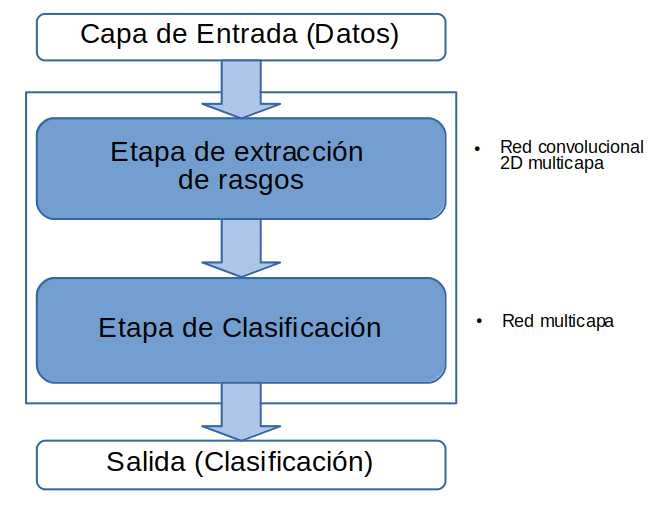

El punto importante en aprendizaje profundo, es que aunque hayamos diseñado nuestra red considerando las distintas tareas que se realizarán (extraxión de rasgos y clasificación), la red será entrenada en su conjunt. Luego, la división que hemos estabecido en el diseño es una referencia, pero la frontera de las tareas será un tanto difusa.

In [ ]:
from keras import layers
from keras import models
convNN = models.Sequential()

Analicemos la primera capa añadida: el tipo de capa es Comv2D (hasta ahoara solo habiamos usado Dense).

Los parámeros son:

``
keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
``

Cuya descripción es:

* **filters**: dimensión del espacio de salida: número de filtros de convolución (serán no-lineales debido a la función de activación) que implementará la capa. \
Para la primera capa, matemáticamente se escribe $x_2 = \phi( H^{(i)} \otimes x_1)$. Donde $x_1$ es la entradad a la primera capa (los datos), y $x_2$ la salida (o entrada a la segunda capa), $H^{(i)}$ es el $i$-ésimo filtro de convolución y $\phi(\cdot)$ la función de activación (es tensorial y se aplica a cada elemento del tensor que resulta de $H^{(i)} \otimes x_1$ ).

* **kernel_size**: dimsnsiones (renglones y columnas) de los filtros $H^{(i)}$
 . Si se da un solo valor, significa que son iguales en todas las dimensiones.

* **strides**: Entero o tupla de dos enteros con el paso de convolución en cada dimensión.

* **padding**: {“valid”, “same”} indica si el resultado tendrá los mismos (num_renglones, num_columnas) que el tensor de entrada o si la convolución solo se aplica sobre datos válidos (con efecto de reducción de bordes).

* **data_format**: {“channels_last”, “channels_first”} indica si los datos de estradad estan en formato
``(batch_size, image_height, image_width, image_channels)``
o
``(batch_size, image_channels, image_height, image_width)``

* **dilation_rate**: entro o tupla de dos enteros indicando la dilatación de la salida en cada dimensión.

* **activation**: función de activación.

* **use_bias**: boleana que indica si se usa vector de sesgo.

* **kernel_initializer**: método de inicialización de los pesos de la matrix kernel.

* **bias_initializer**: método de inicialización de los pesos del vector de sesgo.

* **kernel_regularizer**: método de regularización de los los pesos de la matriz kernel

* **bias_regularizer**: método de regularización de los los pesos del vector de sesgo.

* **kernel_constraint**: resticción sobre los pesos de la matriz kernel (pesos de los filtros)

* **bias_constraint**: resticción sobre los pesos del vector de sesgo.

In [ ]:
convNN.add(layers.Conv2D(filters     =32, 
                         kernel_size =(3, 3), 
                         activation  ='relu', 
                         input_shape =(28, 28, 1)))

El tensor resultante de una capa de convolución será de (batch_size, image_height, image_width, image_channels=filters). Es decir cada filtro genera ahora una canal (respuesta del filtro).

Se espera que:

* la información relevante en forma de relaciones espaciales en la imagen de entrada se codifique en forma de respuesta en algunos canales. T

* pixeles vecinos tengas respuestas similares.

* respuesta altas se asocian con filtros entonados a detectar caractéristicas relevantes

Por ello, ahora, con la finalidad de resaltar la información relevante a la salida de la capa de convolución e aplica un proceso de **pooling** o agrupado. Esto se realiza mediante la capa MaxPooling2D

el formato es

``keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)``

y el significado de los parámetros es

* **pool_size**: entero o tupla indicando las dimensiones de la ventana sobre el que se seleccionará la maxima respuesta.

* **strides**: entero o tupla indicando el paso (default es igual a pool_size)

* **padding**: {“valid”, “same”} indica si el resultado tendrá los mismos (num_renglones, num_columnas) que el tensor de entrada o si la convolución solo se aplica sobre datos válidos (con efecto de reducción de bordes).

* **data_format**: {‘channels_last’ (default), ‘channels_first’}.


In [ ]:
convNN.add(layers.MaxPooling2D(pool_size=(2, 2)))

A contintuación añadimos dos capas mas de convolución, cn un *MaxPoolin* intermedio.

In [ ]:
convNN.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
convNN.add(layers.MaxPooling2D(pool_size=(2, 2)))
convNN.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

Veamos la arquitectura del modelo diseñado, cada vez el tensor de salida se hace espacialmente mas estrecho y con mayor número de canales, es más profunda.

In [ ]:
convNN.summary()

La estrategia es ir tranformando la información espacial en detección (respuesta) de filtros. Por lo que las dimensiones del tensor que se procesa se iran estrechando espacialmente a la vez que se añaden mas capas (filtros).

Las respuestas de la última capa se pueden entender como las características extraídas del vector de entrada.

La siguinete etapoa es alimentar con las características extraidas una red multicapa para realizar la clasificación.

## Etapa de Clasificación mediante una red multicapa

El primer paso es pasar el tensor de rasgos calculado por la etapa previa a un vector unidimensional. Esto lo hacemos con la capa **Flatten**, cuya definición esta dada por
``keras.layers.Flatten(data_format=None)``
que no requiere ningún parámetro.


In [ ]:
convNN.add(layers.Flatten())

Ahora agregamos una red similar con una arquitectura similar a la que usamos para clasificar los dígitos MNIST. La estapa se compone con dos capas Dense, y la de salida es un vector de dimesión 10. Solo que ahora, en la primera capa oculta pondremos menos neuronas, pues los rasgos relevantes se han conservado y la información no relevante habre de haberse desechado.

In [ ]:
convNN.add(layers.Dense(units=64, activation='relu'))
convNN.add(layers.Dense(units=10, activation='softmax'))

y el resumen de la red completa es como sigue:

In [ ]:
convNN.summary()

Como podemos ver, el número de parámetros totales a entrenar es sustancialmente menor que la red multicapa (mas de 400 mil)

Compilamos en modelo, que es definir los parámetrso de la estpa de entrenamiento.

In [ ]:
convNN.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

y procedemos a realizar el entrenamiento

In [ ]:
import time
tic = time.time()

convNN.fit(x = train_images, 
           y = train_labels, 
           epochs    =5, 
           batch_size=64,
          verbose=2)

print('seconds=', time.time()-tic)

Tomó alrededor de 24 segundos con GPU.
Evaluando el modelo 

In [ ]:
test_loss, test_acc = convNN.evaluate(test_images, test_labels)
print('Accuracy:' ,test_acc, ', ¡WOW!')

Mientras la red multicapa alcanzo un 97.8 de precisión, la redconvolucional llegó 99.2%.

Grafiquemos la matriz de confusión para este modelo.

In [ ]:
import numpy as np

test_predicted_labels = convNN.predict(test_images)
test_true_labels      = np.argmax(test_labels,axis=1)
test_predicted_labels = np.argmax(test_predicted_labels,axis=1)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score 
from sklearn.metrics import f1_score, cohen_kappa_score
import seaborn as sns 

C = confusion_matrix(test_true_labels, test_predicted_labels)

f, ax = plt.subplots(figsize=(11, 9))
sns.set()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(C, cmap=cmap, square=True,
                 annot=True, fmt='d', linewidths=.5)
ax.set_title('Matriz de Confusión')
plt.show()

Comparemos con los resultados obtenidos clasificando toda la imagen: